# Imports


In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo

# Decision Trees


## Helper Functions


In [2]:
class Columns:
    AGE = "age"
    JOB = "job"
    MARITAL = "marital"
    EDUCATION = "education"
    DEFAULT = "default"
    BALANCE = "balance"
    HOUSING = "housing"
    LOAN = "loan"
    CONTACT = "contact"
    DAY_OF_WEEK = "day_of_week"
    MONTH = "month"
    DURATION = "duration"
    CAMPAIGN = "campaign"
    PASSED_DAYS = "pdays"
    PREVIOUS = "previous"
    PREVIOUS_OUTCOME = "poutcome"
    TARGET = "y"

In [3]:
def plot_roc_curve(y_prob, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [4]:
def plot_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    classification_report_output = classification_report(y_test, y_pred)
    accuracy_score_lib = accuracy_score(y_test, y_pred)

    tn = cm[0][0]
    tp = cm[1][1]
    fn = cm[1][0]
    fp = cm[0][1]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted: 0", "Predicted: 1"],
        yticklabels=["Actual: 0", "Actual: 1"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print(classification_report_output)
    print(f"Accuracy (Calculated): {accuracy}")
    print(f"Accuracy (Library): {accuracy_score_lib}")
    print(f"Recall: {recall}")
    print(f"precision: {precision}")

## Data Exploration


In [5]:
train_df = pd.read_csv(os.path.join("..", "dataset", "train.csv"))
test_df = pd.read_csv(os.path.join("..", "dataset", "test.csv"))

In [6]:
train_df.head()

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,0.506494,2,0,0.083970,0,0,6,0.048387,-1,0,...,False,False,False,False,False,False,False,False,False,0
1,0.246753,3,0,0.072803,1,0,21,0.032258,175,1,...,False,False,False,False,False,False,True,False,False,0
2,0.181818,3,0,0.175531,0,0,23,0.000000,-1,0,...,False,False,False,False,False,True,False,False,False,0
3,0.441558,2,0,0.073757,0,1,22,0.048387,-1,0,...,False,False,True,False,False,False,False,False,False,0
4,0.428571,1,0,0.088183,0,0,13,0.016129,-1,0,...,False,False,False,False,False,False,False,False,False,0


In [7]:
test_df.head()

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,0.293333,1,0,0.036442,1,1,8,0.018519,-1,0,...,False,False,False,False,False,True,False,False,False,0
1,0.346667,2,0,0.033861,1,0,30,0.018519,-1,0,...,False,False,False,False,False,True,False,False,False,0
2,0.173333,2,0,0.033644,1,0,20,0.074074,-1,0,...,False,False,False,True,False,False,False,False,False,0
3,0.240000,1,0,0.036590,1,0,23,0.055556,-1,0,...,False,False,False,False,False,True,False,False,False,0
4,0.213333,2,0,0.049066,1,0,4,0.000000,-1,0,...,True,False,False,False,False,False,False,False,False,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                31647 non-null  float64
 1   education          31647 non-null  int64  
 2   default            31647 non-null  int64  
 3   balance            31647 non-null  float64
 4   housing            31647 non-null  int64  
 5   loan               31647 non-null  int64  
 6   day_of_week        31647 non-null  int64  
 7   campaign           31647 non-null  float64
 8   pdays              31647 non-null  int64  
 9   previous           31647 non-null  int64  
 10  poutcome           31647 non-null  int64  
 11  job_admin.         31647 non-null  bool   
 12  job_blue-collar    31647 non-null  bool   
 13  job_entrepreneur   31647 non-null  bool   
 14  job_housemaid      31647 non-null  bool   
 15  job_management     31647 non-null  bool   
 16  job_retired        316

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9043 entries, 0 to 9042
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                9043 non-null   float64
 1   education          9043 non-null   int64  
 2   default            9043 non-null   int64  
 3   balance            9043 non-null   float64
 4   housing            9043 non-null   int64  
 5   loan               9043 non-null   int64  
 6   day_of_week        9043 non-null   int64  
 7   campaign           9043 non-null   float64
 8   pdays              9043 non-null   int64  
 9   previous           9043 non-null   int64  
 10  poutcome           9043 non-null   int64  
 11  job_admin.         9043 non-null   bool   
 12  job_blue-collar    9043 non-null   bool   
 13  job_entrepreneur   9043 non-null   bool   
 14  job_housemaid      9043 non-null   bool   
 15  job_management     9043 non-null   bool   
 16  job_retired        9043 

## Modelling


In [10]:
random_state = 42

In [11]:
y_train = train_df[[Columns.TARGET]]
y_test = test_df[[Columns.TARGET]]

x_train = train_df.drop(columns=[Columns.TARGET])
x_test = test_df.drop(columns=[Columns.TARGET])

In [12]:
x_train

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0.506494,2,0,0.083970,0,0,6,0.048387,-1,0,...,False,False,False,False,False,False,False,False,False,False
1,0.246753,3,0,0.072803,1,0,21,0.032258,175,1,...,False,False,False,False,False,False,False,True,False,False
2,0.181818,3,0,0.175531,0,0,23,0.000000,-1,0,...,False,False,False,False,False,False,True,False,False,False
3,0.441558,2,0,0.073757,0,1,22,0.048387,-1,0,...,False,False,False,True,False,False,False,False,False,False
4,0.428571,1,0,0.088183,0,0,13,0.016129,-1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,0.493506,2,0,0.081628,0,0,30,0.016129,-1,0,...,False,False,True,False,False,False,False,False,False,False
31643,0.246753,2,0,0.076626,0,1,30,0.016129,-1,0,...,False,False,False,False,False,False,True,False,False,False
31644,0.103896,2,0,0.078541,0,0,12,0.032258,181,1,...,False,False,False,False,False,False,False,False,False,False
31645,0.519481,1,0,0.083117,0,0,17,0.032258,-1,0,...,False,False,False,False,True,False,False,False,False,False


In [13]:
y_train

,y
0,0
1,0
2,0
3,0
4,0
...,...
31642,0
31643,0
31644,1
31645,0


### Basic Decision Tree

This decision tree is just used with the default parameters and no HP tuning.


In [14]:
results = dict()

In [15]:
def run_model(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]
    return y_pred, y_prob

In [16]:
model_1 = DecisionTreeClassifier(random_state=random_state)

In [17]:
model_1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [18]:
y_pred_model_1, y_prob_model_1 = run_model(model_1, x_train, y_train, x_test)

In [19]:
results["Model 1"] = {"y_pred": y_pred_model_1, "y_prob": y_prob_model_1}

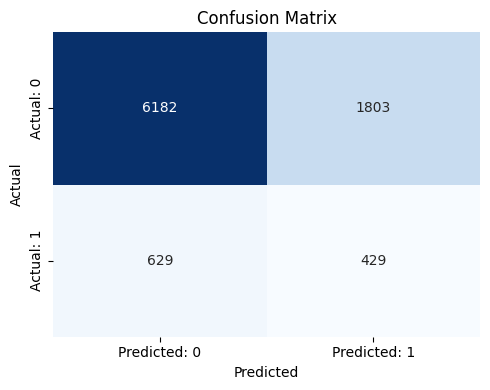

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      7985
           1       0.19      0.41      0.26      1058

    accuracy                           0.73      9043
   macro avg       0.55      0.59      0.55      9043
weighted avg       0.82      0.73      0.77      9043

Accuracy (Calculated): 0.7310627004312729
Accuracy (Library): 0.7310627004312729
Recall: 0.4054820415879017
precision: 0.1922043010752688


In [20]:
plot_confusion_matrix(y_pred_model_1, y_test)

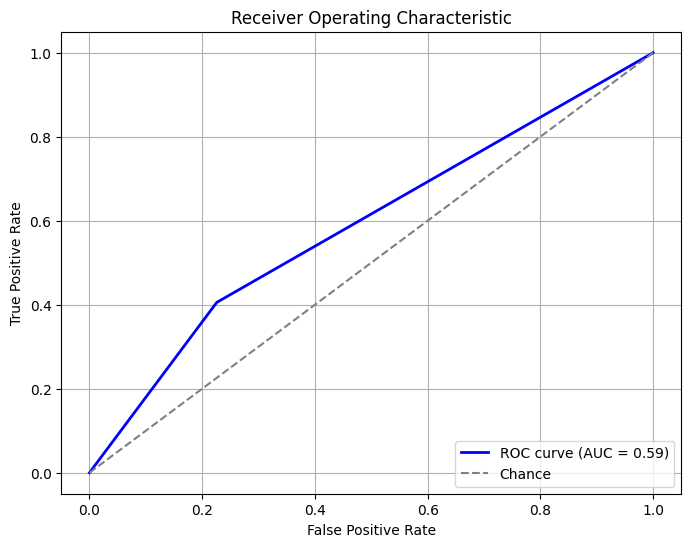

In [21]:
plot_roc_curve(y_prob_model_1, y_test)

### Basic Decision Tree with Max Depth of 3


In [22]:
model_2 = DecisionTreeClassifier(random_state=random_state, max_depth=3)

In [23]:
y_pred_model_2, y_prob_model_2 = run_model(model_2, x_train, y_train, x_test)

In [24]:
results["Model 2"] = {"y_pred": y_pred_model_1, "y_prob": y_prob_model_1}

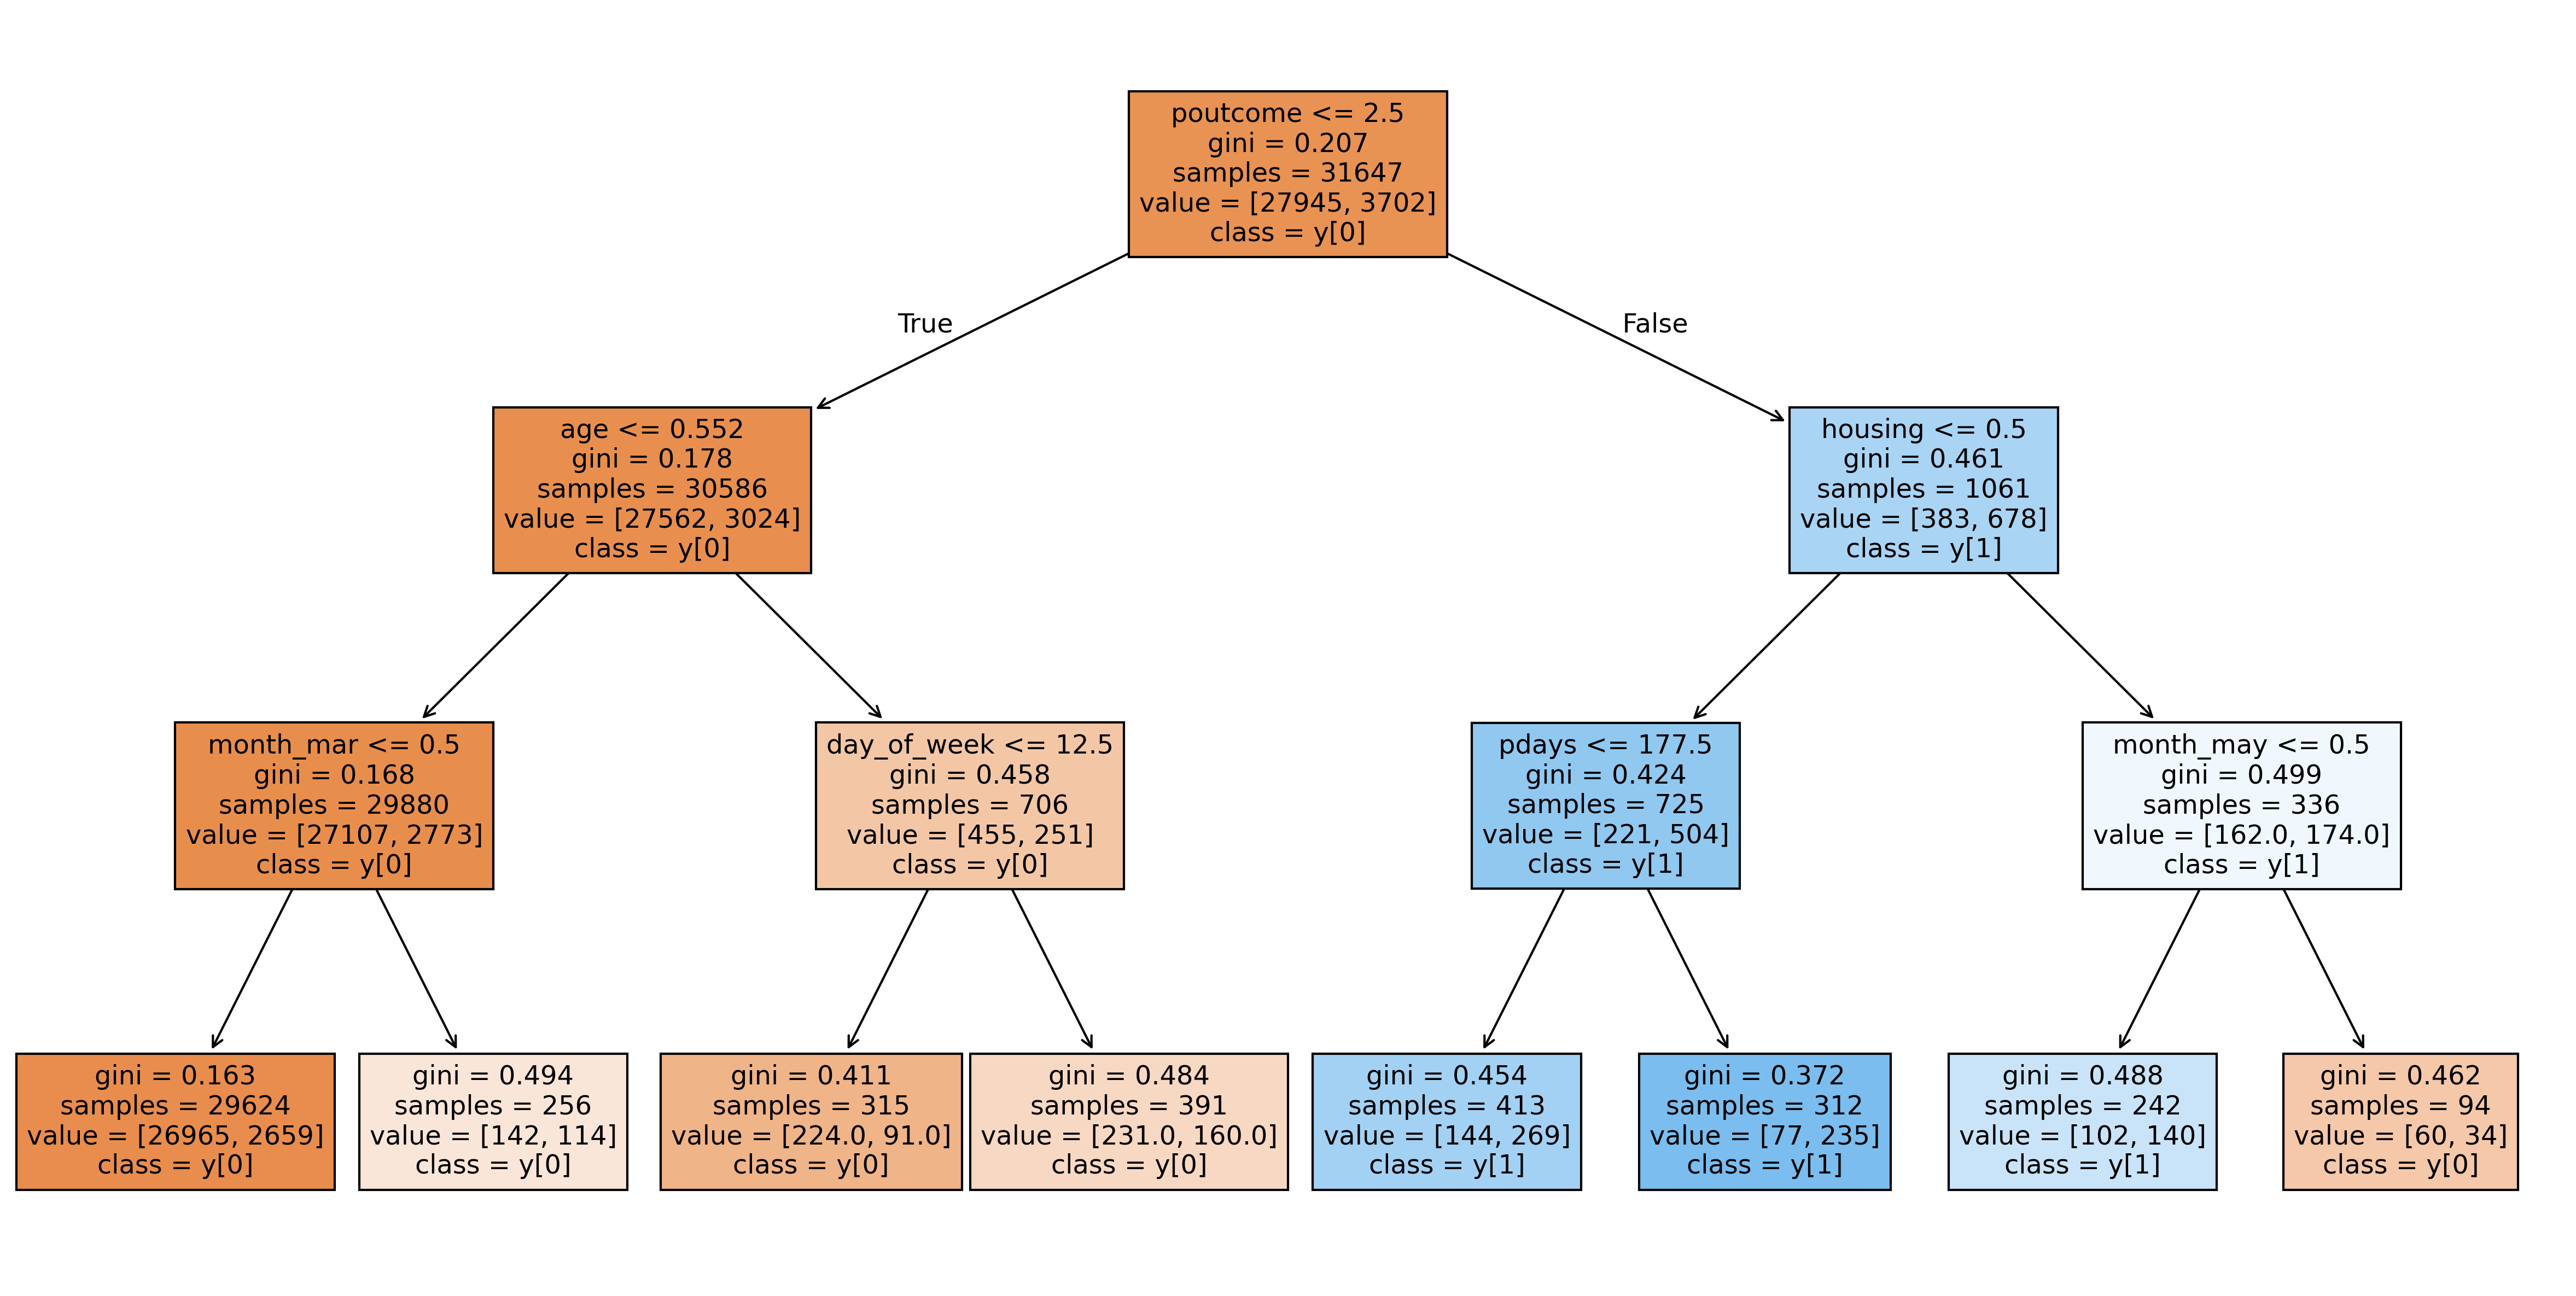

In [25]:
plt.figure(figsize=(20, 10), dpi=300)
tree.plot_tree(model_2, filled=True, feature_names=x_train.columns, class_names=True)
plt.show()

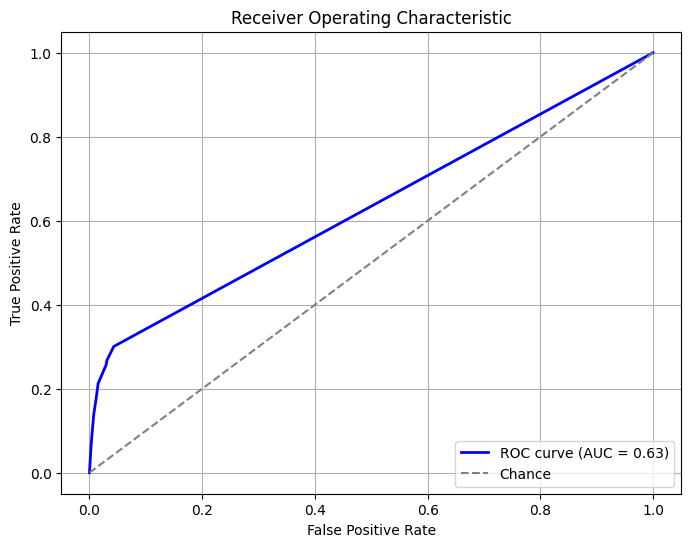

In [26]:
plot_roc_curve(y_prob_model_2, y_test)

### Decision Tree with HP Tuning


In [27]:
param_grid = {
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"],
}

In [28]:
model_3 = GridSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    param_grid=param_grid,
    scoring="roc_auc",
)

In [29]:
model_3.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [30]:
print("Best Parameters:", model_3.best_params_)
model_3 = model_3.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [31]:
y_pred = model_3.predict(x_test)
y_prob = model_3.predict_proba(x_test)[:, 1]

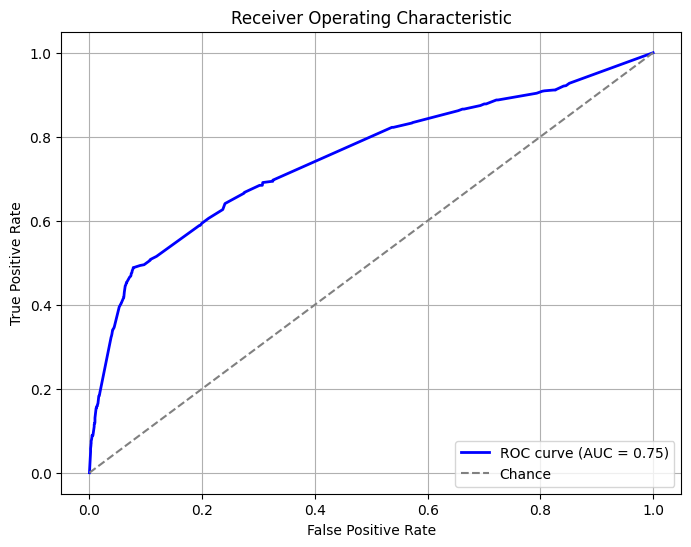

In [32]:
plot_roc_curve(y_prob, y_test)

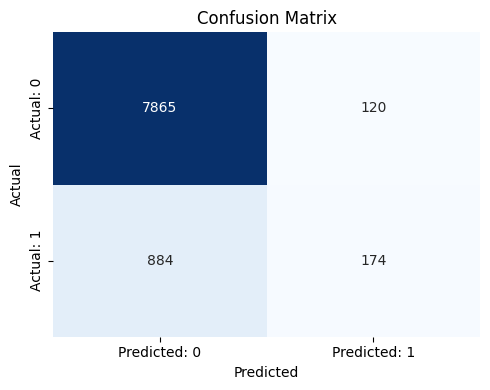

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.59      0.16      0.26      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.57      0.60      9043
weighted avg       0.86      0.89      0.86      9043

Accuracy (Calculated): 0.8889748977109366
Accuracy (Library): 0.8889748977109366
Recall: 0.16446124763705103
precision: 0.5918367346938775


In [33]:
plot_confusion_matrix(y_pred, y_test)

In [34]:
df = pd.DataFrame({"y_test": y_test.squeeze(), "y_prob": y_prob.squeeze()})

df.to_csv(os.path.join("..", "dataset", "dt_roc_values.csv"), index=False)

### Random Forest with HP Tuning


In [35]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"],
}

In [36]:
model_4 = GridSearchCV(
    RandomForestClassifier(random_state=random_state),
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

In [37]:
model_4.fit(x_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklea

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [38]:
print("Best Parameters:", model_4.best_params_)
model_4 = model_4.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [39]:
y_pred = model_4.predict(x_test)
y_prob = model_4.predict_proba(x_test)[:, 1]

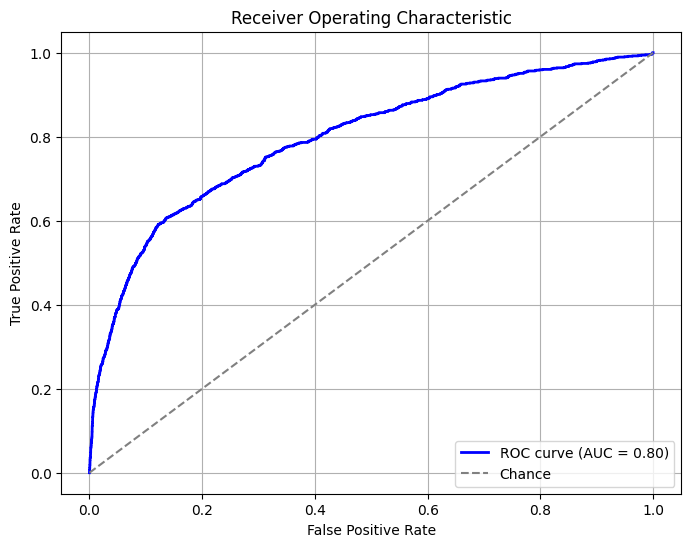

In [40]:
plot_roc_curve(y_prob, y_test)

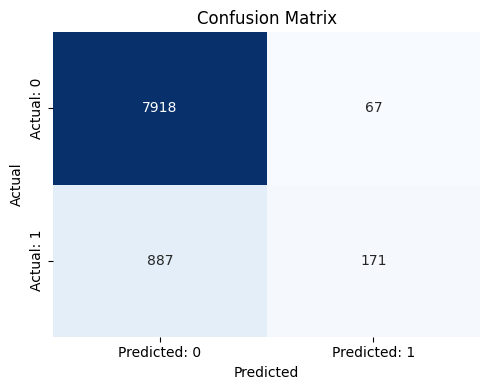

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.72      0.16      0.26      1058

    accuracy                           0.89      9043
   macro avg       0.81      0.58      0.60      9043
weighted avg       0.88      0.89      0.86      9043

Accuracy (Calculated): 0.8945040362711489
Accuracy (Library): 0.8945040362711489
Recall: 0.16162570888468808
precision: 0.7184873949579832


In [41]:
plot_confusion_matrix(y_pred, y_test)

In [42]:
df = pd.DataFrame({"y_test": y_test.squeeze(), "y_prob": y_prob.squeeze()})

df.to_csv(os.path.join("..", "dataset", "rf_roc_values.csv"), index=False)

### SMOTE


In [43]:
smote = SMOTE(random_state=random_state)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [44]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"],
}

In [45]:
model_5 = GridSearchCV(
    RandomForestClassifier(random_state=random_state),
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

In [46]:
model_5.fit(x_resampled, y_resampled)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklea

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [47]:
print("Best Parameters:", model_5.best_params_)
model_5 = model_5.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [48]:
y_pred = model_5.predict(x_test)
y_prob = model_5.predict_proba(x_test)[:, 1]

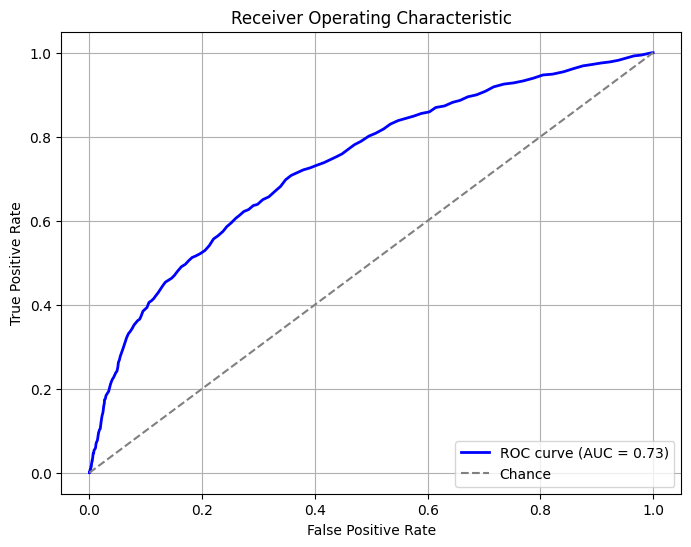

In [49]:
plot_roc_curve(y_prob, y_test)

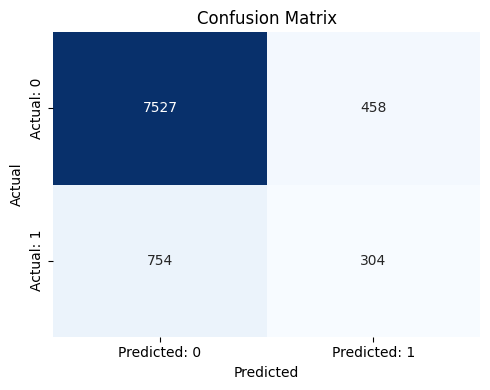

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7985
           1       0.40      0.29      0.33      1058

    accuracy                           0.87      9043
   macro avg       0.65      0.61      0.63      9043
weighted avg       0.85      0.87      0.86      9043

Accuracy (Calculated): 0.8659736813004534
Accuracy (Library): 0.8659736813004534
Recall: 0.28733459357277885
precision: 0.3989501312335958


In [50]:
plot_confusion_matrix(y_pred, y_test)